# Redes Generativas Adversariales (GANs - Generative Adversarial Networks)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = mnist.load_data()

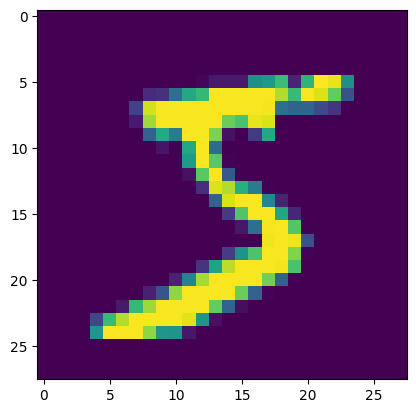

In [4]:
plt.imshow(X_entreno[0])

In [5]:
y_entreno

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Para que el tiempo de entrenamiento sea menor, vamos a filtrar los datos para solo tener de un mismo dígito...se puede escoger cualquiera de los diez dígitos

In [6]:
n = 0
X_filtrado = X_entreno[y_entreno == n]

In [7]:
X_entreno.shape

(60000, 28, 28)

In [8]:
X_filtrado.shape

(5923, 28, 28)

Ahora, a visualizar cualquiera de las imágenes filtradas

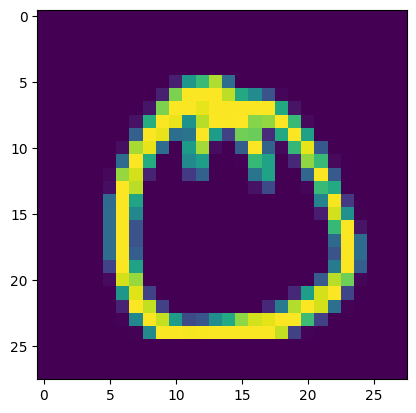

In [9]:
n = 1000
plt.imshow(X_filtrado[n])

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

## Creación del GAN

### Empezar con el generador

El generador es una especie de "decodificador", haciendo referencia al AutoCodificador que ya vimos.  Lo primero que hay que hacer es determinar un tamaño de codificación, o dimensión, que recibirá y que luego ampliará al tamaño de las imágenes en cuestión.  Este número lo seleccionamos nosotros.  Debe ser sustancialmente menor a las imágenes, pero no tan pequeño que se pueda perder alguna información importante.

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# Tamaño de la capa que va hacia el 
#    Generador
tamanio_codificacion = 100

NOTA:
La primera capa se define de 100 neuronas.  Esto no quiere decir que deba ser igual al *tamanio_codificacion* definido arriba.  El número de neuronas lo definimos nosotros y bien podría ser 125, o 150

In [12]:
generador = Sequential()
generador.add(Dense(100, activation = "relu", 
                    input_shape = [tamanio_codificacion]))
generador.add(Dense(150, activation = 'relu'))
generador.add(Dense(784, activation = "sigmoid")) # 28*28 = 784
generador.add(Reshape([28, 28]))  # Esto es lo que espera el discriminador

### Ahora a definir el discriminador

El numero de capas depende nosotros.  Entre más capas se usen, será más difícil confundir al discriminador.  Claro está, que entre más capas mayor capacidad computacional se requiere.

In [13]:
discriminador = Sequential()
discriminador.add(Flatten(input_shape = [28, 28]))
discriminador.add(Dense(150, activation = 'relu'))
discriminador.add(Dense(100, activation = 'relu'))
discriminador.add(Dense(1, activation = "sigmoid"))

discriminador.compile(loss = "binary_crossentropy", 
                      optimizer = "adam")

Nótese que el discriminador se compila, pero el generador no.  En vez, se crea el GAN y se compila la red completa para que el generador se entrene únicamente a través del GAN completo.

También, como se mencionó en la intuición, el discriminador no será entrenado durante la segunda fase

Finalmente, la red GAN también tiene solo como salida un resultado binario

Las siguientes líneas obedecen a estas observaciones

In [14]:
GAN = Sequential([generador, discriminador])

In [15]:
discriminador.trainable = False

In [16]:
GAN.compile(loss = "binary_crossentropy", 
            optimizer = "adam")

Ver un resumen de lo hecho

In [17]:
GAN.layers

In [18]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28)            143634    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 132951    
                                                                 
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [19]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [20]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 150)               117750    
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


### Configurar las tandas para entrenamiento

In [21]:
import tensorflow as tf

In [22]:
# Si se desea que el entrenamiento sea más
#   rápido, se puede tomar un valor mayor
tamanio_tanda = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

El tamaño del "buffer" en el Conjunto_Datos.shuffle() puede afectar la aleatoridad de conjunto de datos, y por lo tanto el orden en los cuales aparecen los elementos. 

In [23]:
# mis_datos = X_entreno
mis_datos = X_filtrado

In [24]:
datos = tf.data.Dataset.from_tensor_slices(mis_datos).shuffle(buffer_size = 1000)

In [25]:
type(datos)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [26]:
datos = datos.batch(tamanio_tanda, 
                    drop_remainder = True).prefetch(1)

In [27]:
epocas = 1   # Debiera ser suficiente para ver algo, pero se puede cambiar

**NOTA: el generador nunca vé imágenes verdaderas.  Aprende viendo las gradientes que fluyen hacia atrás en el discriminador.  Entre mejor se va poniendo el discriminador a través del entrenamiento, más información está contenida en sus gradientes. Esto hace que el generador vaya progresando en su aprendizaje sobre cómo generar imágenes falsas.** 


## Iteración de Entrenamiento

Normalmente se usa el .fit() para entrenar.  Sin embargo como acá se tienen dos redes en competencia (adversariales), se creará una iteración de entrenamiento

In [28]:
# Tomar los componentes por separado
generador, discriminador = GAN.layers

In [29]:
for epoca in range(epocas):
    print(f"Voy por la época {epoca + 1}")
    i = 0
    # Para cada tanda en el conjunto de datos
    for X_tanda in datos:
        i = i + 1
        if i % 100 == 0:
            print(f"\tVoy por la tanda número {i} de {len(mis_datos) // tamanio_tanda}")
            
        ###############################################
        ## Fase 1 -  Entrenamiento del DISCRIMINADOR ##
        ###############################################
        
        # Crear Ruido
        ruido = tf.random.normal(shape = [tamanio_tanda, 
                                          tamanio_codificacion])
        
        # Generar imágenes falsas (números) basadas sólo en una entrada de ruido
        # Notar que el Generador nunca vé imágenes reales (solo ruido)
        imagenes_gen = generador(ruido)
        
        # Concatenar las Imágenes Generadas con las Verdaderas
        # Para poder utilizar tf.concat, los tipos de los datos deben
        #    coincidir!
        X_falso_vs_real = tf.concat([imagenes_gen, 
                                     tf.dtypes.cast(X_tanda,
                                                    tf.float32)], 
                                     axis = 0)
        
        # Las metas se fijan en cero (0) para imágenes falsas 
        #     y uno (1) para imágenes reales
        y1 = tf.constant([[0.]] * tamanio_tanda + [[1.]] * tamanio_tanda)
        
        # La siguiente instrucción obvia una advertencia de Keras
        discriminador.trainable = True
        
        # Entrenar al discriminador con esta tanda
        discriminador.train_on_batch(X_falso_vs_real, y1)
        
        
        ##########################################
        ## Fase 2 - Entrenamiento del GENERADOR ##
        ##########################################
        
        # Crear algo de ruido
        ruido = tf.random.normal(shape=[tamanio_tanda, 
                                        tamanio_codificacion])
        
        # En esta fase se quiere que el discriminador crea 
        #   que las imágenes falsas son reales
        y2 = tf.constant([[1.]] * tamanio_tanda)
        
        # Evitar una advertencia
        discriminador.trainable = False
        
        GAN.train_on_batch(ruido, y2)
        
print("Entrenamiento Completado")            

Voy por la época 1
	Voy por la tanda número 100 de 185
Entrenamiento Completado


Lo más probable es que el generador solo aprenda a crear un tipo de imagen del número ruidoso.  Sin importar cuál es el ruido que se le pasa.

https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same

**Ahora que está todo entrenado, se puede probar solo el generador para producir imágenes**

In [30]:
ruido = tf.random.normal(shape = [10, tamanio_codificacion])

In [31]:
ruido.shape

TensorShape([10, 100])

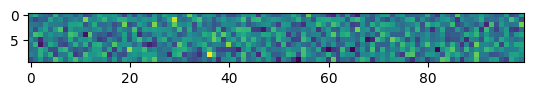

In [32]:
plt.imshow(ruido)

In [33]:
imagenes = generador(ruido)

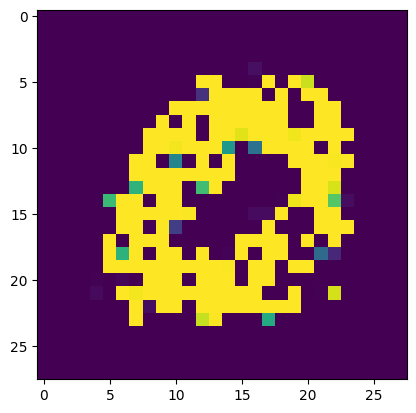

In [34]:
n = 5
plt.imshow(imagenes[n])

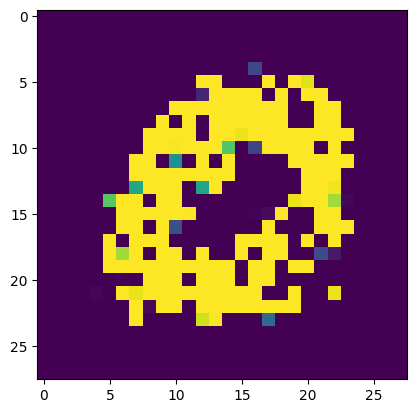

In [35]:
n = 9
plt.imshow(imagenes[n])

**Si se ven las 10 imágenes, todas parecen ser escencialmente lo mismo.  Hay algunas diferencias, algunos puntos cambian de intensidad pero básicamente es la misma imagen.**

**El generador encontró una imagen que logra confundir al discriminador y ya no "se preocupa" por generar nuevas...el generador entró en *modo colapsado***


**En este campo, este es el  estado-del-arte!  Para obtener resultados realistas, se requieren GPUs de mucha potencia!**